In [146]:
import logging
import random

import networkx as nx
import osmnx as ox
from matplotlib import pyplot as plt

import proj as pj


stream = logging.StreamHandler()
pj.logger.addHandler(stream)
pj.logger.setLevel(logging.INFO)

## Get graph from OSM

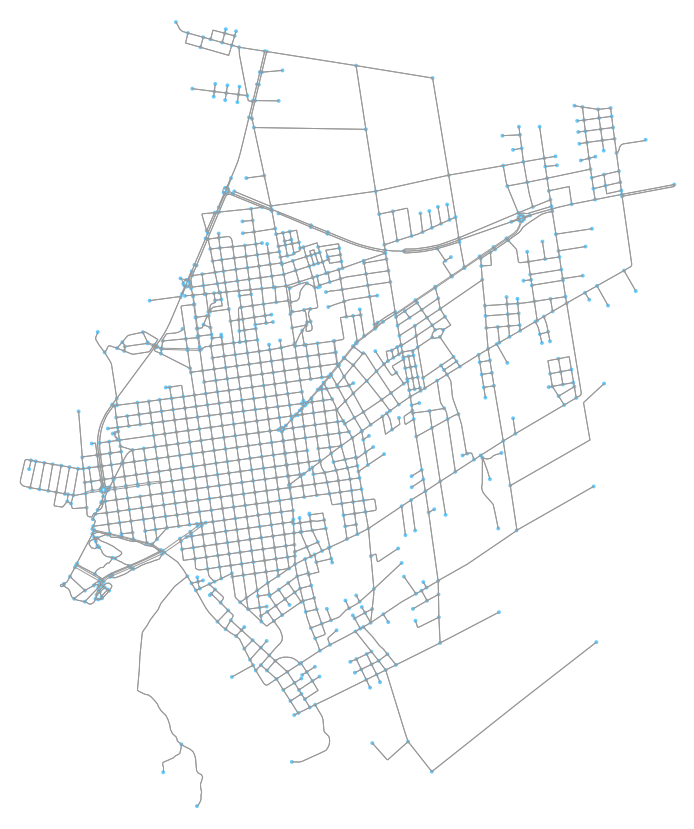

(<Figure size 1076.99x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe9f5a63790>)

In [147]:
g = pj.geo.normalize_osm(ox.graph_from_place('Treinta y Tres, Treinta y Tres, Uruguay'))
ox.plot_graph(g, fig_height=15)

In [148]:
print(f'Nodes: {g.number_of_nodes()}')
print(f'Edges: {g.number_of_edges()}')
print(f'Multigraph: {g.is_multigraph()}')
print(f'Directed: {g.is_directed()}')

Nodes: 1358
Edges: 4132
Multigraph: True
Directed: True


In [149]:
odcount = 1
min_distance = 0.06
seed = 123

random.seed(seed)

nodes = list(g.nodes())
demand = {}
for _ in range(odcount):
    while True:
        ods = random.sample(nodes, k=2)
        if pj.geo.plane_distance(g, *ods) > min_distance:
            demand[tuple(ods)] = random.uniform(100, 2000)
            break

infras = {
    'cost_factors': [0.9, 0.5, 0.4],
    'construction_cost_factors': [1, 4, 8]
}
budget = 500

In [150]:
pj.config.update_configuration(
    max_iter=1,
    arc_weight_key="length",
    pulse_discard_faraway_nodes=True,
    pulse_queue_key_factor=2.5
)

solution = pj.solve(g, infras, demand, budget)
solution.print()

Base primal bound per od {(1481701874, 1481702908): 6733.437999999999}
Base primal bound per od {(1481701874, 1481702908): 6733.437999999999}
Base primal bound per od {(1481701874, 1481702908): 6733.437999999999}
Base primal bound per od {(1481701874, 1481702908): 6733.437999999999}
INFO:proj:Base primal bound per od {(1481701874, 1481702908): 6733.437999999999}



      Solution:
      4825126.347188279

      Budget used: 497.028
      Modifications:
      {(1481701874, 1481702908): {(1481701874, 1481701879, 1): 164.365, (1481701879, 1481701880, 1): 137.291, (1481701880, 1481701882, 1): 113.559, (1481701882, 1481701894, 0): 0, (1481701894, 2134400741, 0): 0, (2134400741, 2134400742, 0): 0, (2134400742, 1374290335, 0): 0, (1374290335, 2134400746, 1): 22.317, (2134400746, 2134400767, 0): 0, (2134400767, 2134400766, 2): 59.496, (2134400766, 1481701958, 0): 0, (1481701958, 2134400776, 0): 0, (2134400776, 1481702012, 0): 0, (1481702012, 2134400811, 0): 0, (2134400811, 2134400815, 0): 0, (2134400815, 1481702083, 0): 0, (1481702083, 1481702103, 0): 0, (1481702103, 1481702130, 0): 0, (1481702130, 2471698484, 0): 0, (2471698484, 2134400838, 0): 0, (2134400838, 1481702161, 0): 0, (1481702161, 1481702189, 0): 0, (1481702189, 1481702213, 0): 0, (1481702213, 4374074363, 0): 0, (4374074363, 1481702236, 0): 0, (1481702236, 1481702294, 0): 0, (1481702294, 148

In [151]:
for o, d in demand.keys():
    print(pj.networkx.astar_path(g, source=o, target=d, weight='length'))

([1481701874, 1481701879, 1481701880, 1481701887, 1481701894, 2134400741, 2134400742, 1374290335, 2134400746, 2134400767, 2134400766, 1481701958, 2134400776, 1481702012, 2134400811, 2134400815, 1481702083, 1481702103, 1481702130, 2471698484, 2134400838, 1481702161, 1481702189, 1481702213, 4374074363, 1481702236, 1481702294, 1481702310, 1481702336, 1481702347, 1481702363, 1481702385, 4374074383, 4374074379, 1481702422, 4374075805, 4374075999, 4374076000, 1481702466, 1481702476, 2471698521, 1481702500, 1481702502, 1481702505, 2426904193, 1481702519, 1481702524, 1481702528, 1481702531, 1481702534, 1481702537, 1481702540, 1481702545, 1481702548, 1481702551, 1481702558, 1481702568, 1481702572, 1481702668, 1481702680, 1481702809, 1481702823, 2142183295, 1481702932, 1481702934, 1481702906, 1481702918, 1481702936, 4374164561, 1481702950, 1481702973, 1481702986, 1481702984, 1481702978, 1481702962, 1481702942, 1481702930, 1481702908], 6733.437999999999)


## Draw result

In [152]:
def draw_solution(graph, solution, cmap=['orange', 'blue', 'green', 'black']):
    """
    Draw solution obtained by the pulse solver
    """
    
    def get_xy(graph, n1, n2):
        return list(zip(graph.nodes[n1]['pos'], graph.nodes[n2]['pos']))
    
    fig, ax = ox.plot_graph(g, fig_height=15, show=False, close=False)
    for odpair, data in solution.shortest_paths.items():
        path = data['path']
        for n1, n2 in zip(path[:-1], path[1:]):
            ax.plot(*get_xy(graph, n1, n2), 'r--', linewidth=2)
        
        for edge in solution.modifications[odpair].keys():
            n1, n2, infra = edge
            if infra > 0:
                ax.plot(*get_xy(graph, n1, n2), c=cmap[infra], linewidth=4)
    
        source, target = odpair
        ax.scatter(*graph.nodes[source]['pos'], s=100, c='red', zorder=4)
        ax.scatter(*graph.nodes[target]['pos'], s=100, c='red', zorder=4)
            
    return fig, ax

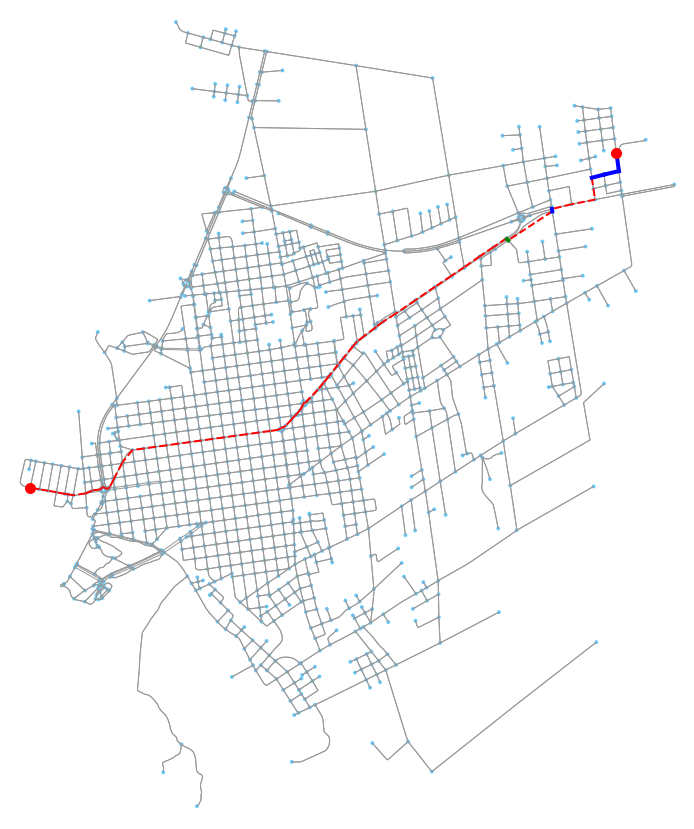

In [153]:
fig, ax = draw_solution(g, solution)

In [154]:
print('y', ax.get_ylim())
print('x', ax.get_xlim())

y (-33.261175986000005, -33.195209514)
x (-54.406907056, -54.341124144)
